In [2]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import scanpy as sc
from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell
from pyscenic.export import export2loom, add_scenic_metadata
import igraph
from chord import Chord
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize
import matplotlib as mpl
import seaborn as sns
def savesvg(fname: str, fig, folder: str='') -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format='svg')

In [3]:
ex_matrix = sc.read_h5ad('./0.1_res_pred.h5ad').to_df() # 读取数据，两个是一样的
adata = sc.read_h5ad('./0.1_res_pred.h5ad')

In [4]:
ex_matrix.head()

,HES4,ISG15,AGRN,SCNN1D,CFAP74,PRDM16,SMIM1,AL365255.1,ACOT7,TAS1R1,...,PNMA6A,U52111.1,HCFC1-AS1,UBL4A,SLC10A3,MPP1,TMLHE-AS1,MT-ATP8,MT-ND3,AC011043.1
AAACCTGAGACTACAA-1,-0.220596,0.947074,-0.039303,-0.028158,-0.01734,-0.017368,-0.101735,-0.048985,-0.164294,-0.033057,...,-0.023302,-0.0261,-0.025025,-0.227586,-0.196716,-0.280712,-0.073928,-0.203595,-0.252455,-0.050937
AAACCTGAGAGCTGCA-1,-0.220596,-0.590191,-0.039303,-0.028158,-0.01734,-0.017368,-0.101735,-0.048985,-0.164294,-0.033057,...,-0.023302,-0.0261,-0.025025,-0.227586,-0.196716,-0.280712,-0.073928,-0.203595,1.000000,-0.050937
AAACCTGAGATCACGG-1,-0.220596,1.000000,-0.039303,-0.028158,-0.01734,-0.017368,-0.101735,-0.048985,-0.164294,-0.033057,...,-0.023302,-0.0261,-0.025025,1.000000,-0.196716,-0.280712,-0.073928,-0.203595,-0.813083,-0.050937
AAACCTGAGGATTCGG-1,-0.220596,0.865301,-0.039303,-0.028158,-0.01734,-0.017368,-0.101735,-0.048985,-0.164294,-0.033057,...,-0.023302,-0.0261,-0.025025,-0.227586,-0.196716,-0.280712,-0.073928,-0.203595,0.315789,-0.050937
AAACCTGAGGTCGGAT-1,-0.220596,1.000000,-0.039303,-0.028158,-0.01734,-0.017368,-0.101735,-0.048985,-0.164294,-0.033057,...,-0.023302,-0.0261,-0.025025,-0.227586,-0.196716,-0.280712,-0.073928,-0.203595,-1.004715,-0.050937


In [5]:
tf_names = load_tf_names('../common/regular/hs_hgnc_tfs.txt') # 读取转录因子名字的列表

In [10]:
# 数据库 下载地址 https://resources.aertslab.org/cistarget/databases/
db_fnames = glob.glob('../common/regular/hg38*.mc9nr.genes_vs_motifs.rankings.feather') # 读取reference 数据库
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings")]

In [11]:
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True) # 计算邻接矩阵

preparing dask client
parsing input
creating dask graph
10 partitions
computing dask graph
shutting down client and local cluster
finished


In [12]:
adjacencies.to_csv('./data/adjacencies.tsv', index=False, sep='\t')

In [13]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))


2022-12-01 22:31:42,605 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-12-01 22:31:42,649 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-12-01 22:31:44,692 - pyscenic.utils - INFO - Creating modules.


In [14]:
with open('./data/modules.p', 'wb') as f:
    pickle.dump(modules, f)

In [15]:
df = prune2df(dbs, modules, './motifs.tbl') # 读取转录因子的注释


2022-11-24 16:29:58,937 - pyscenic.transform - WARNING - Less than 80% of the genes in MAF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:29:59,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNTL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:00,435 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BACH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:00,499 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:01,408 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38__refseq-r80__10kb_up_an


2022-11-24 16:30:08,735 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:08,843 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:08,940 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:09,461 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:10,514 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_


2022-11-24 16:30:14,423 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:14,953 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:15,012 - pyscenic.transform - WARNING - Less than 80% of the genes in BARX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:16,727 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:17,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LMX1B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.


2022-11-24 16:30:29,807 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VENTX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:30,505 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF117 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:30,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF205 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:30,782 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF358 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:30,970 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF391 could be mapped to


2022-11-24 16:30:47,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:48,026 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:48,528 - pyscenic.transform - WARNING - Less than 80% of the genes in VENTX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:49,552 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:30:49,665 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_v


2022-11-24 16:31:08,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:08,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EPAS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:08,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:10,886 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:12,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI3 could be mapped to hg38__


2022-11-24 16:31:30,439 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:30,506 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF768 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:30,569 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF772 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:30,698 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSWIM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:30,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG2 could be mapped to hg38__refseq-


2022-11-24 16:31:42,099 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:42,156 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:42,212 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:42,378 - pyscenic.transform - WARNING - Less than 80% of the genes in HHEX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:42,411 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.ra


2022-11-24 16:31:49,695 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:49,756 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:50,336 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:50,397 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:50,434 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.ra


2022-11-24 16:31:56,198 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:56,435 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:56,563 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:57,236 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:31:57,340 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rank


2022-11-24 16:32:05,702 - pyscenic.transform - WARNING - Less than 80% of the genes in HLX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:32:05,747 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:32:05,792 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPLL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:32:05,865 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.

2022-11-24 16:32:05,925 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.

In [17]:
df.to_csv('motifs.csv')

In [18]:
regulons = df2regulons(df)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [19]:
with open('regulons.p', 'wb') as f:
    pickle.dump(regulons, f)

In [20]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=1)

100%|████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00, 10.00it/s]


/Users/ckw/miniforge3/envs/sc/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


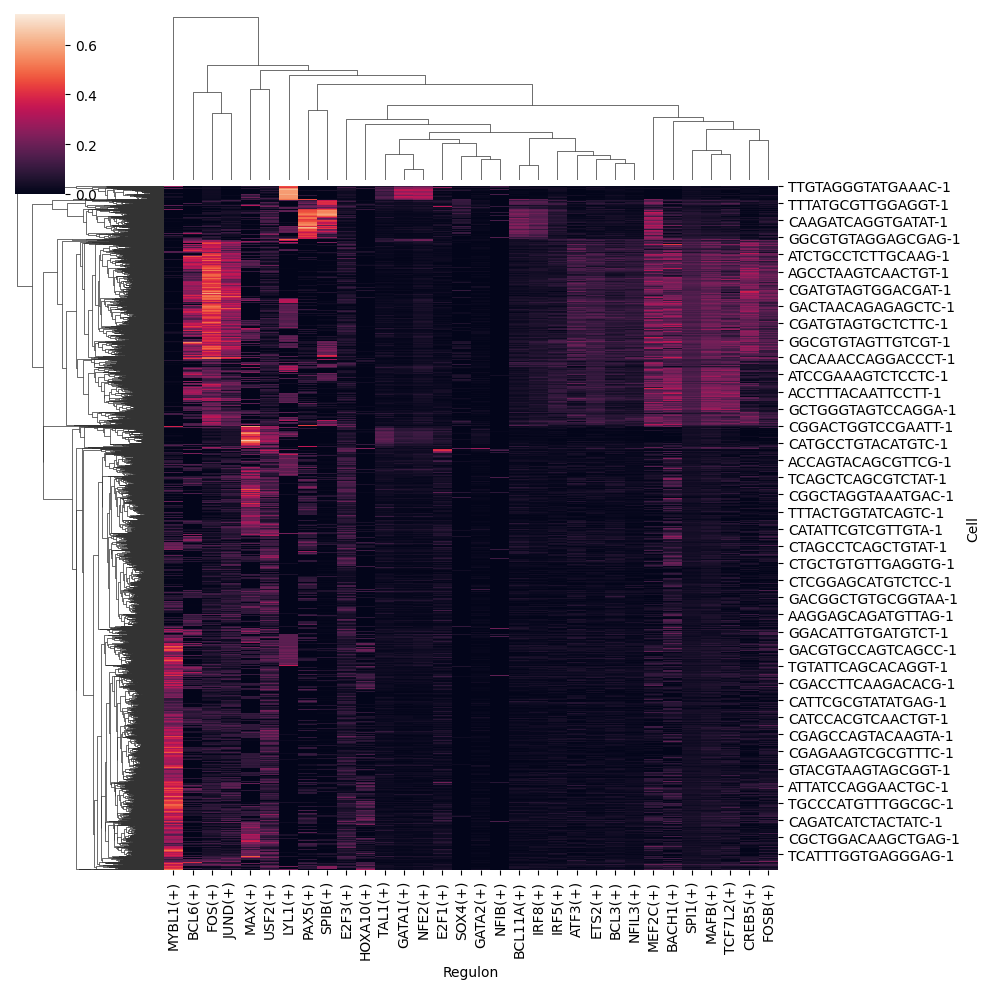

In [21]:
sns.clustermap(auc_mtx)
# plt.savefig('12312312.jpg')

# RSS panel plot with all cell types

In [22]:
rss_cellType = regulon_specificity_scores( auc_mtx, adata.obs['leiden'])
rss_cellType

,ATF3(+),BACH1(+),BCL11A(+),BCL3(+),BCL6(+),CREB5(+),E2F1(+),E2F3(+),ETS2(+),FOS(+),...,NFE2(+),NFIB(+),NFIL3(+),PAX5(+),SOX4(+),SPI1(+),SPIB(+),TAL1(+),TCF7L2(+),USF2(+)
Monocyte|Macrophage,0.588568,0.546166,0.406952,0.542922,0.549763,0.614822,0.310747,0.345665,0.611624,0.622812,...,0.395781,0.176703,0.583672,0.262473,0.336085,0.580608,0.330742,0.338421,0.583720,0.307915
Natural killer cell|Natural killer T (NKT) cell,0.302044,0.310967,0.325487,0.346520,0.291428,0.297694,0.425063,0.416028,0.310899,0.314454,...,0.351106,0.191011,0.341063,0.253021,0.186797,0.342620,0.251053,0.386668,0.341968,0.442109
Megakaryocyte|Platelet,0.174385,0.172180,0.184793,0.186193,0.170171,0.182139,0.225324,0.205319,0.181402,0.186292,...,0.342328,0.220838,0.182405,0.171495,0.183598,0.195121,0.171500,0.328666,0.183879,0.225251
T cell,0.307476,0.355158,0.342216,0.340746,0.277034,0.277203,0.428661,0.451180,0.305238,0.278878,...,0.349415,0.196218,0.306947,0.360385,0.192158,0.317227,0.259222,0.396334,0.292074,0.437862
B cell,0.207769,0.209713,0.389949,0.211494,0.191113,0.190163,0.228074,0.207589,0.211468,0.193309,...,0.216860,0.212869,0.207166,0.463229,0.375986,0.226227,0.437114,0.217196,0.214582,0.223157
Plasmacytoid dendritic cell,0.175003,0.173567,0.196034,0.174579,0.169319,0.171376,0.179060,0.171915,0.177058,0.170567,...,0.175223,0.167445,0.175578,0.185484,0.248934,0.175083,0.215483,0.174376,0.174063,0.173727


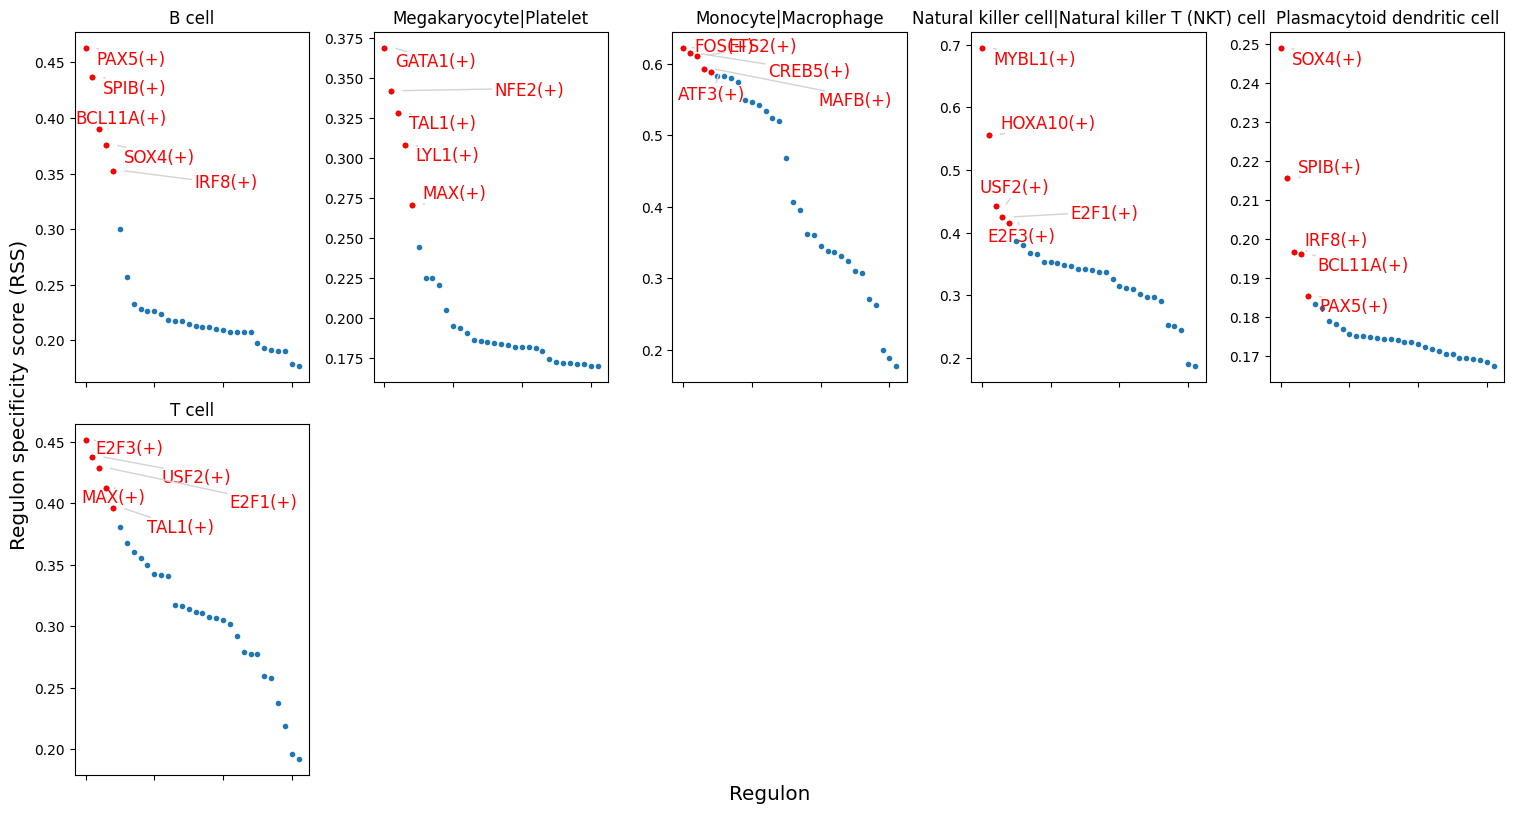

In [23]:
cats = sorted(list(set(adata.obs['leiden'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 ) 

fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [24]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [25]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

In [26]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [27]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in adata.obs['leiden'] ]

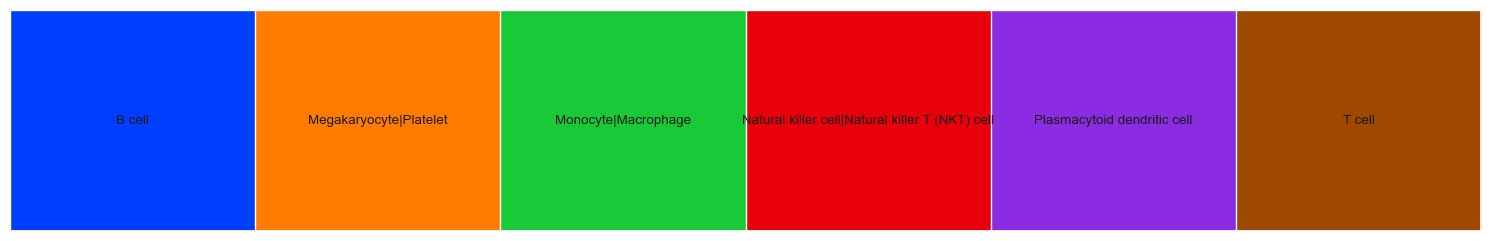

In [28]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=2.5 )
plt.savefig("cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

In [29]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

Regulon,ATF3(+),BACH1(+),BCL11A(+),BCL3(+),BCL6(+),CREB5(+),E2F1(+),E2F3(+),ETS2(+),FOS(+),...,NFE2(+),NFIB(+),NFIL3(+),PAX5(+),SOX4(+),SPI1(+),SPIB(+),TAL1(+),TCF7L2(+),USF2(+)
Cell,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACTACAA-1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
AAACCTGAGAGCTGCA-1,0,1,0,0,1,1,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
AAACCTGAGATCACGG-1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGAGGATTCGG-1,1,0,0,1,1,1,0,0,1,1,...,0,0,0,0,1,1,1,0,0,0
AAACCTGAGGTCGGAT-1,0,1,0,0,1,1,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0


/var/folders/0q/0x0df50j27b1w78yn0n106jc0000gp/T/ipykernel_15228/2426484170.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
/var/folders/0q/0x0df50j27b1w78yn0n106jc0000gp/T/ipykernel_15228/2426484170.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

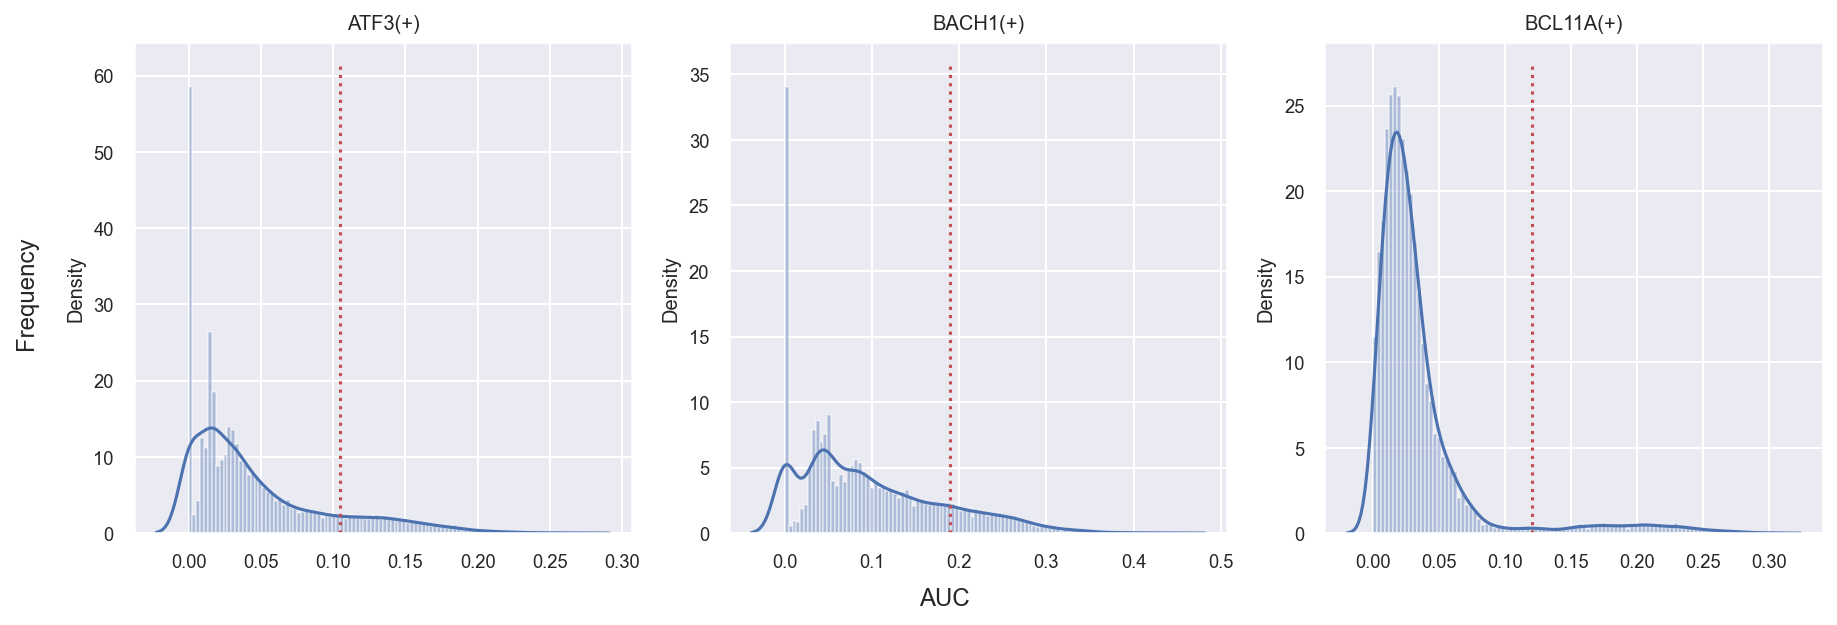

In [30]:
# select regulons:
r = binary_mtx.columns[:3]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('ellType-binaryPlot2.pdf', dpi=600, bbox_inches='tight')

In [31]:
rss_leiden = regulon_specificity_scores( auc_mtx, adata.obs['leiden'] )
rss_leiden

,ATF3(+),BACH1(+),BCL11A(+),BCL3(+),BCL6(+),CREB5(+),E2F1(+),E2F3(+),ETS2(+),FOS(+),...,NFE2(+),NFIB(+),NFIL3(+),PAX5(+),SOX4(+),SPI1(+),SPIB(+),TAL1(+),TCF7L2(+),USF2(+)
Monocyte|Macrophage,0.588568,0.546166,0.406952,0.542922,0.549763,0.614822,0.310747,0.345665,0.611624,0.622812,...,0.395781,0.176703,0.583672,0.262473,0.336085,0.580608,0.330742,0.338421,0.583720,0.307915
Natural killer cell|Natural killer T (NKT) cell,0.302044,0.310967,0.325487,0.346520,0.291428,0.297694,0.425063,0.416028,0.310899,0.314454,...,0.351106,0.191011,0.341063,0.253021,0.186797,0.342620,0.251053,0.386668,0.341968,0.442109
Megakaryocyte|Platelet,0.174385,0.172180,0.184793,0.186193,0.170171,0.182139,0.225324,0.205319,0.181402,0.186292,...,0.342328,0.220838,0.182405,0.171495,0.183598,0.195121,0.171500,0.328666,0.183879,0.225251
T cell,0.307476,0.355158,0.342216,0.340746,0.277034,0.277203,0.428661,0.451180,0.305238,0.278878,...,0.349415,0.196218,0.306947,0.360385,0.192158,0.317227,0.259222,0.396334,0.292074,0.437862
B cell,0.207769,0.209713,0.389949,0.211494,0.191113,0.190163,0.228074,0.207589,0.211468,0.193309,...,0.216860,0.212869,0.207166,0.463229,0.375986,0.226227,0.437114,0.217196,0.214582,0.223157
Plasmacytoid dendritic cell,0.175003,0.173567,0.196034,0.174579,0.169319,0.171376,0.179060,0.171915,0.177058,0.170567,...,0.175223,0.167445,0.175578,0.185484,0.248934,0.175083,0.215483,0.174376,0.174063,0.173727


In [32]:
import operator as op
from IPython.display import HTML, display
def fetch_logo(regulon, base_url =  "http://motifcollections.aertslab.org/v9/logos/"):
    for elem in regulon.context:
        if elem.endswith('.png'):
#             return '{}{}'.format(v)
            return '<img src="{}{}" style="max-height:124px;"></img>'.format(base_url, elem)
    return ""

In [33]:
df_regulons = pd.DataFrame(data=[list(map(op.attrgetter('name'), regulons)),
                                 list(map(len, regulons)),
                                 list(map(fetch_logo, regulons))], index=['name', 'count', 'logo']).T

In [34]:
MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
display(HTML(df_regulons.head().to_html(escape=False)))
pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

/var/folders/0q/0x0df50j27b1w78yn0n106jc0000gp/T/ipykernel_15228/2364496528.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,name,count,logo
0,ATF3(+),50,
1,BACH1(+),21,
2,BCL11A(+),159,
3,BCL3(+),161,
4,BCL6(+),7,


In [35]:
aucell_adata = sc.AnnData(X=auc_mtx.sort_index())
aucell_adata.obs = adata.obs
names = list(map(op.attrgetter('name'), filter(lambda r: r.score > 2.0, regulons)))


/var/folders/0q/0x0df50j27b1w78yn0n106jc0000gp/T/ipykernel_15228/1951099206.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  aucell_adata = sc.AnnData(X=auc_mtx.sort_index())


/Users/ckw/miniforge3/envs/sc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


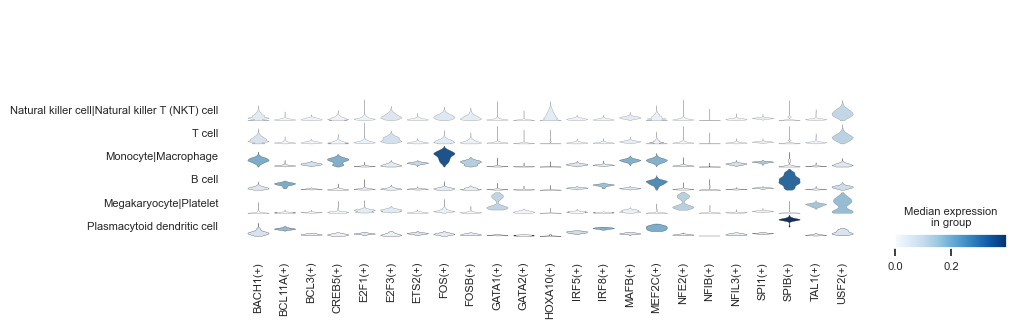

In [36]:
sc.pl.stacked_violin(aucell_adata, names, groupby='leiden')

In [37]:
add_scenic_metadata(adata, auc_mtx, regulons)

AnnData object with n_obs × n_vars = 11699 × 3000
    obs: 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Regulon(ATF3(+))', 'Regulon(BACH1(+))', 'Regulon(BCL11A(+))', 'Regulon(BCL3(+))', 'Regulon(BCL6(+))', 'Regulon(CREB5(+))', 'Regulon(E2F1(+))', 'Regulon(E2F3(+))', 'Regulon(ETS2(+))', 'Regulon(FOS(+))', 'Regulon(FOSB(+))', 'Regulon(GATA1(+))', 'Regulon(GATA2(+))', 'Regulon(HOXA10(+))', 'Regulon(IRF5(+))', 'Regulon(IRF8(+))', 'Regulon(JUND(+))', 'Regulon(LYL1(+))', 'Regulon(MAFB(+))', 'Regulon(MAX(+))', 'Regulon(MEF2C(+))', 'Regulon(MYBL1(+))', 'Regulon(NFE2(+))', 'Regulon(NFIB(+))', 'Regulon(NFIL3(+))', 'Regulon(PAX5(+))', 'Regulon(SOX4(+))', 'Regulon(SPI1(+))', 'Regulon(SPIB(+))', 'Regulon(TAL1(+))', 'Regulon(TCF7L2(+))', 'Regulon(USF2(+))'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersio

In [38]:
df_obs = adata.obs
signature_column_names = list(df_obs.select_dtypes('number').columns)
signature_column_names = list(filter(lambda s: s.startswith('Regulon('), signature_column_names))
df_scores = df_obs[signature_column_names + ['leiden']]
df_results = ((df_scores.groupby(by='leiden').mean() - df_obs[signature_column_names].mean())/ df_obs[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['regulon'] = list(map(lambda s: s[8:-1], df_results.regulon))
df_results[(df_results.Z >= 3.0)].sort_values('Z', ascending=False).head()

,leiden,regulon,Z
186,Plasmacytoid dendritic cell,SOX4(+),6.190348
175,Plasmacytoid dendritic cell,IRF8(+),4.153071
157,Megakaryocyte|Platelet,TAL1(+),3.851575
188,Plasmacytoid dendritic cell,SPIB(+),3.822264
139,Megakaryocyte|Platelet,GATA1(+),3.727522


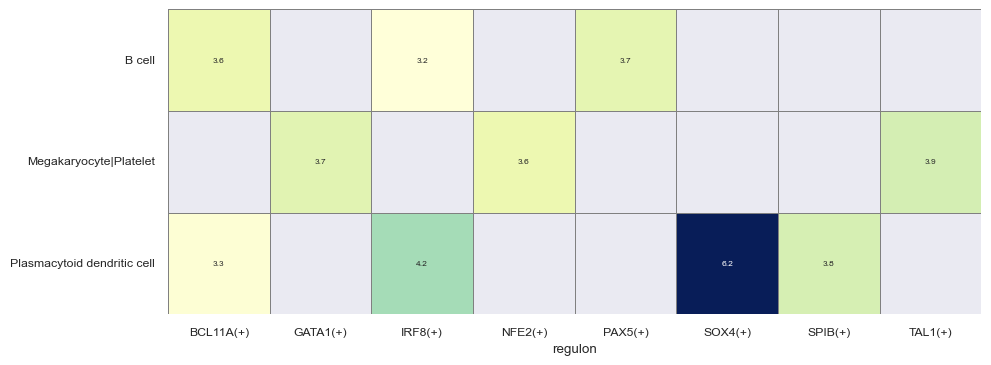

In [39]:
df_heatmap = pd.pivot_table(data=df_results[df_results.Z >= 3.0].sort_values('Z', ascending=False),
                           index='leiden', columns='regulon', values='Z')
#df_heatmap.drop(index='Myocyte', inplace=True) # We leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 6})
ax1.set_ylabel('')
savesvg('heatmap - GSE103322 - regulons.svg', fig)

In [40]:
import networkx as nx

In [85]:
nx.draw_networkx?

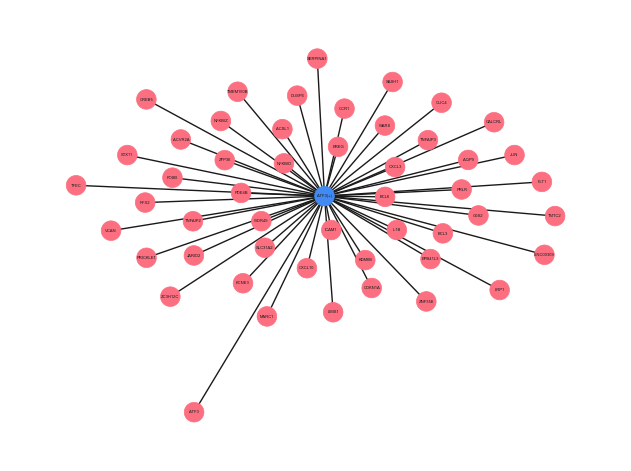

In [104]:
for val in regulons:
    tmp_G = nx.Graph()
    nNodes = len(val)
    node_cr = ['#428AF3'] + len(val) * ['#FC6F81']
    node_lb = [val.name] + list(val.gene2weight.keys())
#     node_shape = 'o'
    tmp_G.add_node(val.name, node_shape='s')
    for g in val.gene2weight.keys():
        tmp_G.add_edge(val.name, g, weight=val.gene2weight[g])
    
    nx.draw_networkx(tmp_G,node_color=node_cr, 
                     label=node_lb,
                     font_size=3,
                     node_shape=node_shape,
                     linewidths=0.5,
                    node_size=200)
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig('123.jpg',dpi=1000)
    plt.show()
    break

In [44]:
nNodes

50